# Random Forest Visualizations Notebook 

#### Library Import Station

In [10]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import ConfusionMatrixDisplay

sns.set(style="whitegrid", font_scale=1.1)



#### Pickle Loading 

In [11]:
#  Load the Random Forest bundle 
bundle_path = "../../Results/Pickle_Bundles/rf_bundle.pkl"

with open(bundle_path, "rb") as f:
    bundle = pickle.load(f)

print("Bundle keys:", bundle.keys())

# Core pieces
rf_model   = bundle["rf_final_model"]
y_test     = bundle["y_test"]        # pandas Series
y_pred     = bundle["y_pred"]        # numpy array
y_proba    = bundle["y_proba"]       # numpy array (n_samples, n_classes)
cm         = bundle["confusion_matrix"]

# Feature importance + names
rf_importance   = bundle["rf_feature_importance"]
feature_names   = bundle["rf_feature_names"]  # or bundle["feature_names"]

# Data for PDPs (sampled X so plotting is faster)
X_pdp = bundle["X_test_sample"]      # pandas DataFrame (2000 x 198)

print("Model classes:", rf_model.classes_)
print("y_test shape:", y_test.shape)
print("y_proba shape:", y_proba.shape)
print("X_pdp shape:", X_pdp.shape)

Bundle keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'log_loss', 'roc_auc_ovr', 'params', 'rf_feature_importance', 'rf_feature_names', 'feature_names', 'X_test_sample', 'rf_final_model', 'X_train_sample', 'y_train_sample'])
Model classes: [1 3 4]
y_test shape: (90649,)
y_proba shape: (90649, 3)
X_pdp shape: (2000, 198)


### Figure 1: Confusion Matrix

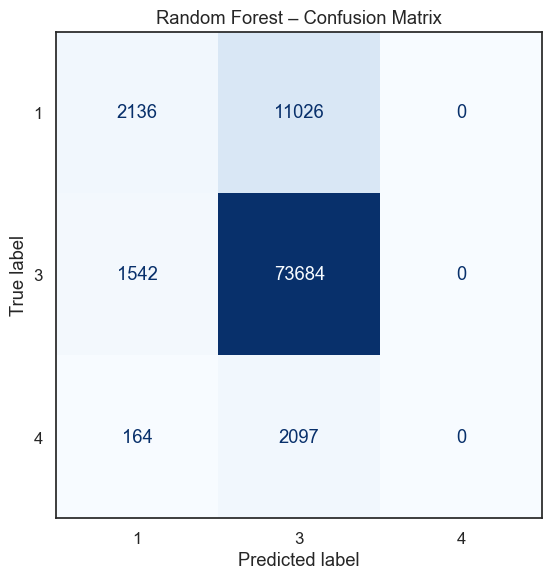

In [12]:
classes = rf_model.classes_   # array([1, 3, 4])

# Use a clean style (no grid)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", colorbar=False, ax=ax)

# Remove any grid lines seaborn may try to add
ax.grid(False)

ax.set_title("Random Forest – Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

plt.tight_layout()
# plt.savefig("../../Results/Visualizations/rf_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()



### Plot Description — Random Forest Confusion Matrix

This confusion matrix visualizes how well the Random Forest model distinguishes between the three diabetes-related classes in the BRFSS dataset:

- 1 = No diabetes
- 3 = Pre-diabetes or borderline diabetes
- 4 = Diabetes

The model **performs strongly for Class 3**, correctly identifying a large majority of pre-diabetic individuals. However, a substantial number of both non-diabetic and diabetic respondents are misclassified as Class 3. Notably, the model rarely predicts Class 4 (diabetes), reflecting a challenge in detecting true diabetes cases—likely due to class imbalance and feature overlap between Classes 3 and 4.
Overall, the matrix illustrates where the model succeeds and where additional class-balancing or threshold tuning may be needed.

### Figure 2: ROC Curve

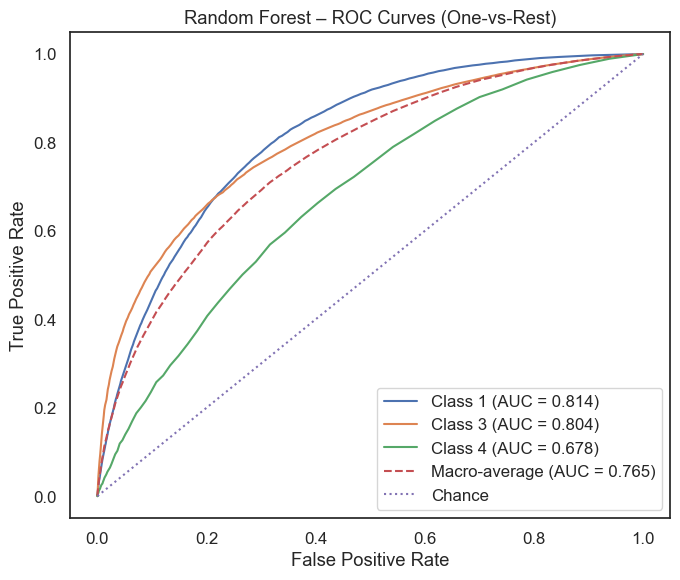

In [13]:
classes = rf_model.classes_
n_classes = len(classes)

# Binarize y_test for OvR ROC
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)
for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7,6))

for c in classes:
    plt.plot(fpr[c], tpr[c], label=f"Class {c} (AUC = {roc_auc[c]:.3f})")

plt.plot(all_fpr, mean_tpr, linestyle="--",
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], linestyle=":", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest – ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.tight_layout()

# plt.savefig("../../Results/Visualizations/rf_roc_curves.png", dpi=300, bbox_inches="tight")

plt.show()


### Plot Description — ROC Curves (One-vs-Rest)

The ROC curves evaluate the model’s ability to distinguish each class from the others in a one-vs-rest framework. The AUC (Area Under the Curve) values summarize predictive performance:

- Class 1 (No diabetes): AUC ≈ 0.81 — strong separability
- Class 3 (Pre-diabetes): AUC ≈ 0.80 — strong separability
- Class 4 (Diabetes): AUC ≈ 0.68 — moderate separability

The **macro-average AUC ≈ 0.76** indicates that overall, the model has good discriminatory power. The lower AUC for Class 4 suggests the model struggles most with distinguishing diabetic individuals from pre-diabetic respondents. This aligns with real-world challenges where symptom profiles and health metrics overlap between these groups.

### Figure 3: Gini-based Feature Importance Plot

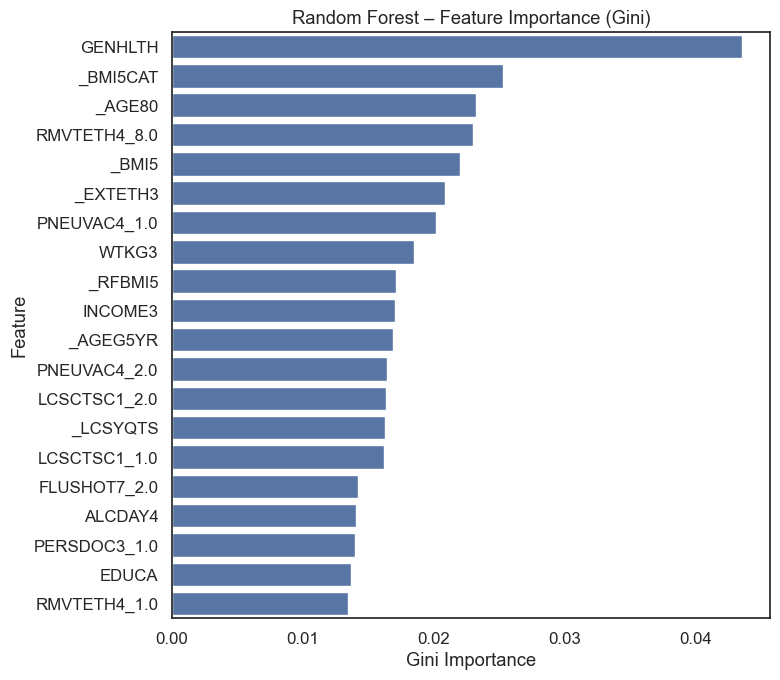

In [14]:
# Sort by importance (descending)
indices = np.argsort(rf_importance)[::-1]
top_n = 20   # change if you want fewer/more features
top_idx = indices[:top_n]

plt.figure(figsize=(8,7))
sns.barplot(
    x=rf_importance[top_idx],
    y=np.array(feature_names)[top_idx],
    orient="h"
)

plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Random Forest – Feature Importance (Gini)")
plt.tight_layout()

# plt.savefig("../../Results/Visualizations/rf_feature_importance.png", dpi=300, bbox_inches="tight")

plt.show()



### Plot Description — Random Forest Feature Importance (Gini Importance)

This plot ranks the most influential features driving the Random Forest’s predictions. The top predictors include:

- **GENHLTH (General Health Rating)**
- **BMI indicators (_BMI5CAT, _BMI5)**
- **Age variables (_AGE80, _AGEG5YR)**
- **Oral health measures (e.g., RMVTETH4_8.0)**
- **Health utilization and chronic condition indicators**

These features align strongly with known risk factors for diabetes. Higher BMI, older age, and poorer general or oral health are well-established predictors of elevated diabetes risk. The plot highlights that the model is leveraging clinically meaningful variables rather than noise, increasing confidence in the model’s interpretability and relevance.

### Figure 4: Partial Dependence of Top Feature

Top feature for PDP: GENHLTH
Target class for PDP: 4


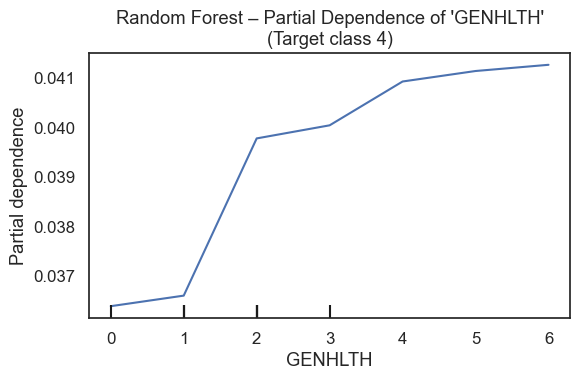

In [15]:
# Use the same indices you used for the feature importance plot
indices = np.argsort(rf_importance)[::-1]
top_feature_index = indices[0]
top_feature_name  = feature_names[top_feature_index]

# Highest-risk class label (you can change this if you want another class)
high_risk_class = rf_model.classes_[-1]   # this is 4 in your case

print(f"Top feature for PDP: {top_feature_name}")
print(f"Target class for PDP: {high_risk_class}")

fig, ax = plt.subplots(figsize=(6, 4))

PartialDependenceDisplay.from_estimator(
    rf_model,
    X_pdp,                # DataFrame with columns matching feature_names
    [top_feature_name],   # use column name
    target=high_risk_class,  # IMPORTANT: pass the *label* (4), not the index
    kind="average",
    ax=ax,
)

ax.set_title(
    f"Random Forest – Partial Dependence of '{top_feature_name}'\n"
    f"(Target class {high_risk_class})"
)
plt.tight_layout()
# plt.savefig("../../Results/Visualizations/rf_partial_dependence_top_feature.png",
#             dpi=300, bbox_inches="tight")
plt.show()



### Plot Description — Partial Dependence of GENHLTH for Class 4 (Diabetes)

This partial dependence plot shows how changes in **GENHLTH (self-rated general health)** affect the model’s predicted probability of Class 4 (diabetes), holding all other features constant.

Since BRFSS codes general health as
1 = Excellent → 5 = Poor,
the upward trend reflects a clinically intuitive relationship: individuals who report poorer general health have a higher modeled probability of having diabetes. The monotonic increase reinforces that self-perceived health is a meaningful and integrated summary measure of underlying conditions—capturing chronic disease burden, lifestyle factors, and overall wellness.